### Classificeren met Randomforest

Een Randomforest is een complexer model dat veel verschillende beslisbomen gebruikt. Dit model kan beter omgaan met complexere data dan het SGD model. <br>
Desondanks verwacht ik dat ook Randomforest niet geweldig zal wereken opp onze dataset, maar wel beter dan het SGD model.

In [2]:
# laden van libraries

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
import sys
import tensorflow as tf

sys.path.insert(0, "..")
sys.path

# loading libraries, some settings for plots
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# directory bepalen
datadir_processed = Path("../data/processed")

# functies beschikbaar maken
from src.data import make_dataset_simple
from src.visualization import visualize_simple




We maken eerst weer de datasets,

In [3]:
# data en label definiëren
data = [] 
labels = []

# met behulp van loop alle foto's in de 10 subdirectories doorlopen
for f in sorted(os.listdir(datadir_processed)):
    folder = os.path.join(datadir_processed, f)
    if os.path.isdir(folder):
        
        for i in sorted(os.listdir(folder)):
            image=tf.keras.preprocessing.image.load_img(folder+'/'+i, color_mode='grayscale', # omzetten naar 1 channel voor lineair model
            target_size= (64,64))
            image=np.array(image)
            data.append(image)
            labels.append(f)    # foldernaam als label

data = np.array(data)
labels = np.array(labels) 


# train en testset maken
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3,
                                                random_state=42)

# uitkomst checken
print(X_train.shape)
print(X_test.shape)

(12415, 64, 64)
(5321, 64, 64)


En ik zet de data weer om naar een vector.

In [4]:
# the -1 tells the method .reshape() to reshape to a matrix where the amount that should be at -1 is deducted from the other amounts.
# because the first number is 14.188, reshape will make sure the second value is 4096, because that is the only way
# to make a matrix with 14.188 rows, in this case.
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape)
print(X_test.shape)

(12415, 4096)
(5321, 4096)


In [5]:
# Data scalen om het model te helpen
X_scale = make_dataset_simple.scale(X_train)

2022-02-13 07:58:27.198 | INFO     | src.data.make_dataset_simple:scale:17 - Run standardscaler on data.


# Pipeline en Gridsearch
Met behulp van een pipeline en gridsearch kan ik het model gaan tunen, dat wil zeggen de beste parameters vinden voor het model

In [6]:
# we make a pipe
# running will take about 4 minutes
pipe = Pipeline(
    [
        ("rfc", RandomForestClassifier(random_state=1))
    ]
)

# set a grid
param_grid = {'rfc__max_depth': np.arange(20, 60, 10),
              'rfc__n_estimators': np.arange(40, 100, 20)}

gridsearch = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=4)
gridsearch.fit(X_train, y_train)
gridsearch.best_params_

{'rfc__max_depth': 30, 'rfc__n_estimators': 80}

Ik maak een heatmap om de verschillende uitkomsten te vergelijken.

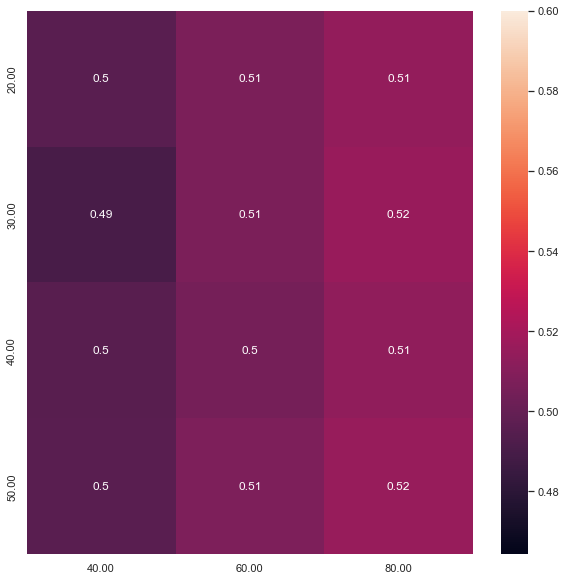

In [7]:
visualize_simple.gridsearch_heatmap(gridsearch, param_grid, vmin = 0.6, figsize=(10,10))

Het ontloopt elkaar niet veel, maar ik zie wel wat verschil. Ik bouw nu een model met de beste parameters. Ik gebruik cross-validation voor een robuustere uitkomst. <br>
Ik maak weer een heatmap voor de uitkomsten per klasse.

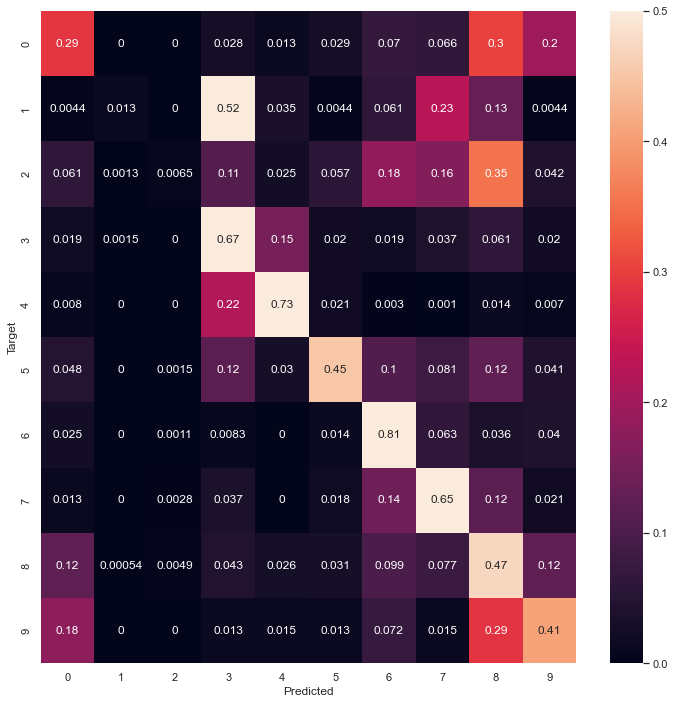

In [8]:
pipe.set_params(**gridsearch.best_params_) # bouw een model met de best gevonden parameters
rf = pipe.fit(X_train, y_train)

yhat = cross_val_predict(rf, X_scale, y_train, cv = 3) # 3x cross validation

cfm = confusion_matrix(y_train, yhat) # confusion matrix
visualize_simple.cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.5)

Dit valt voor sommige klassen niet eens tegen. Het Randomforest model presteert een stuk beter dan het SGD model. Alleen klassen 1 en 2 blijven erg achter. <br> 
Dit zijn de klassen met de minste aantallen, en ze zijn waarschijnlijk ook erg lastig te classificeren als ik naar de voorbeelden kijk.

In [9]:
# classificatie rapport
print(classification_report(y_train,yhat))

                       precision    recall  f1-score   support

        Barred Spiral       0.39      0.29      0.33      1431
  Cigar Shaped Smooth       0.43      0.01      0.03       228
            Disturbed       0.23      0.01      0.01       767
   Edge-on with Bulge       0.53      0.67      0.59      1320
Edge-on without Bulge       0.67      0.73      0.70       995
              Merging       0.70      0.45      0.55      1302
         Round Smooth       0.62      0.81      0.71      1816
 Smooth, Cigar shaped       0.57      0.65      0.61      1421
Unbarred Loose Spiral       0.35      0.47      0.40      1835
Unbarred Tight Spiral       0.42      0.41      0.41      1300

             accuracy                           0.52     12415
            macro avg       0.49      0.45      0.43     12415
         weighted avg       0.50      0.52      0.49     12415



Ik bekijk nog wat foto's van de 'Disturbed' klasse, misschien krijg ik een idee waarom deze klasse zo slecht presteert. 

Found 17736 files belonging to 10 classes.


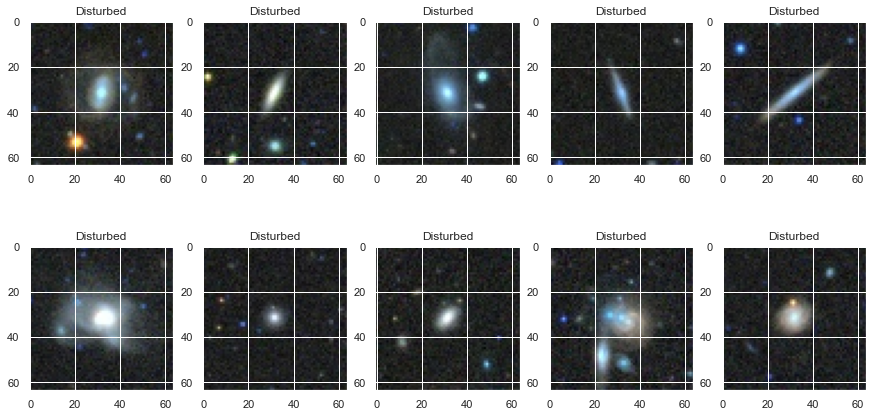

In [14]:
# bekijk 10 foto's van 'Disturbed' klasse

whole = tf.keras.utils.image_dataset_from_directory(
    datadir_processed, labels='inferred', label_mode='int', image_size=(64,
    64)) # dataset puur voor het tonen van foto's

class_name = 'Disturbed'
plt.figure(figsize=(15, 20))
for i in range(10):
    filtered_whole = whole.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_whole.take(1):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_name)
        plt.axis('on')

Dit lijkt wel een verzameling van alle andere klassen door elkaar! Logisch dat een model hier niet goed mee om kan gaan. Ik verwacht dat geen enkel model hier een goede uitkomst op gaat geven.

# Observaties en conclusies

Dit model presteert zoals verwacht beter dan het SGD model, maar nog niet geweldig. Ook zijn er twee klassen die eruit springen (klasse 2 en 3) omdat ze wel heel erg slecht scoren. <br>
Nu ga ik kijken of een neuraal netwerk het beter doet, dat verwacht ik wel.
